<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/ml_SMOTE_eng_pt_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week5: The goal of this notebook is to apply multi-label SMOTE to the dataset of top10 genre in Eng/Es/Pt.


### Data preparation

In [1]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.1 MB/s 


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [4]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [5]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

id_genres.csv

Number of genres: 853
Counter({'rock': 25731, 'pop': 22013, 'electronic': 12769, 'alternative rock': 8103, 'indie rock': 7943, 'metal': 6459, 'folk': 6106, 'singer-songwriter': 5793, 'classic rock': 5688, 'soul': 5458, 'experimental': 4489, 'rap': 4414, 'indie pop': 4141, 'hard rock': 3855, 'punk': 3652, 'ambient': 3645, 'synthpop': 3034, 'post-hardcore': 2938, 'new wave': 2859, 'progressive rock': 2802, 'hardcore': 2790, 'mpb': 2700, 'jazz': 2641, 'emo': 2537, 'post-punk': 2485, 'soundtrack': 2473, 'hip hop': 2408, 'pop punk': 2223, 'metalcore': 2210, 'lo-fi': 2064, 'death metal': 2030, 'dream pop': 1963, 'progressive metal': 1945, 'pop rock': 1898, 'shoegaze': 1835, 'funk': 1814, 'country': 1786, 'k-pop': 1661, 'black metal': 1604, 'blues': 1559, 'latin': 1557, 'post-rock': 1530, 'electropop': 1423, 'house': 1412, 'psychedelic rock': 1322, 'thrash metal': 1257, 'industrial': 1247, 'grunge': 1193, 'electronica': 1178, 'britpop': 1170, 'gothic metal': 1169, 'doom metal': 1150, 'melodic

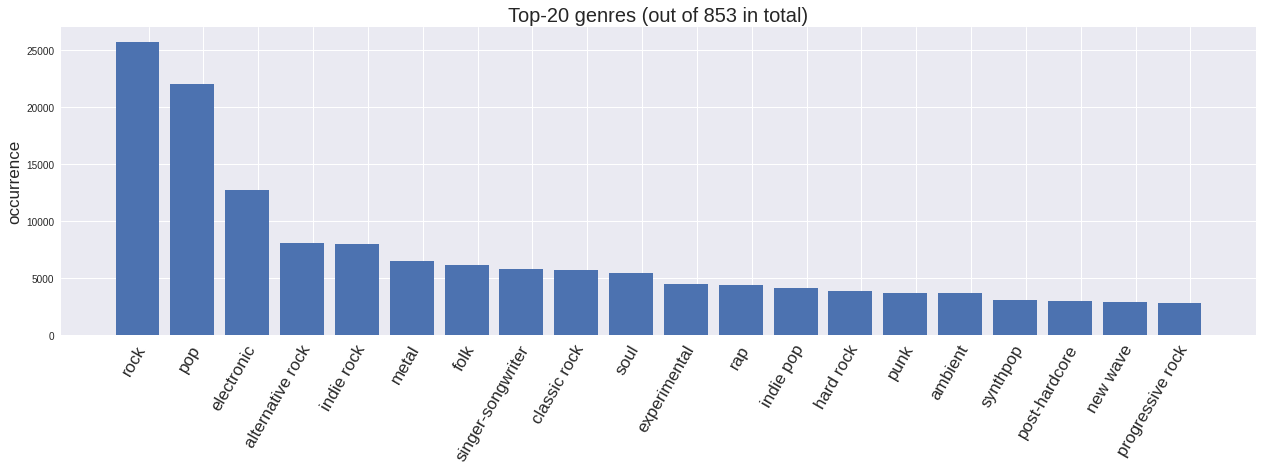

In [6]:
genre_counter = analyze_genre_tag_csv('id_genres.csv', top_n=20)
print(genre_counter)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [7]:
#create List of top20 genre
top20_genre=["pop","rock", "electronic","alternative rock","indie rock", 
              "metal","folk","singer-songwriter","classic rock","soul"
              ,"experimental","rap","indie pop","hard rock","punk"
              ,"ambient","synthpop","post-hardcore","new wave","progressive rock"] #pop

#filter genre dataset as top20 genre only.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(top20_genre)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

Number of lang: 46
Counter({'en': 84103, 'INTRUMENTAL': 9417, 'pt': 7020, 'es': 3225, 'ko': 1145, 'fr': 994, 'ja': 615, 'de': 577, 'pl': 446, 'it': 437, 'sv': 231, 'ru': 187, 'id': 140, 'tr': 125, 'fi': 105, 'no': 99, 'nl': 59, 'tl': 42, 'hr': 41, 'hu': 27, 'sw': 21, 'uk': 20, 'el': 18, 'ca': 18, 'ro': 18, 'da': 17, 'ar': 17, 'et': 16, 'so': 16, 'vi': 13, 'af': 8, 'lt': 7, 'cy': 7, 'sl': 7, 'fa': 6, 'sq': 5, 'th': 4, 'zh-cn': 4, 'pa': 2, 'lv': 2, 'bn': 2, 'cs': 2, 'hi': 1, 'sk': 1, 'bg': 1, 'he': 1})


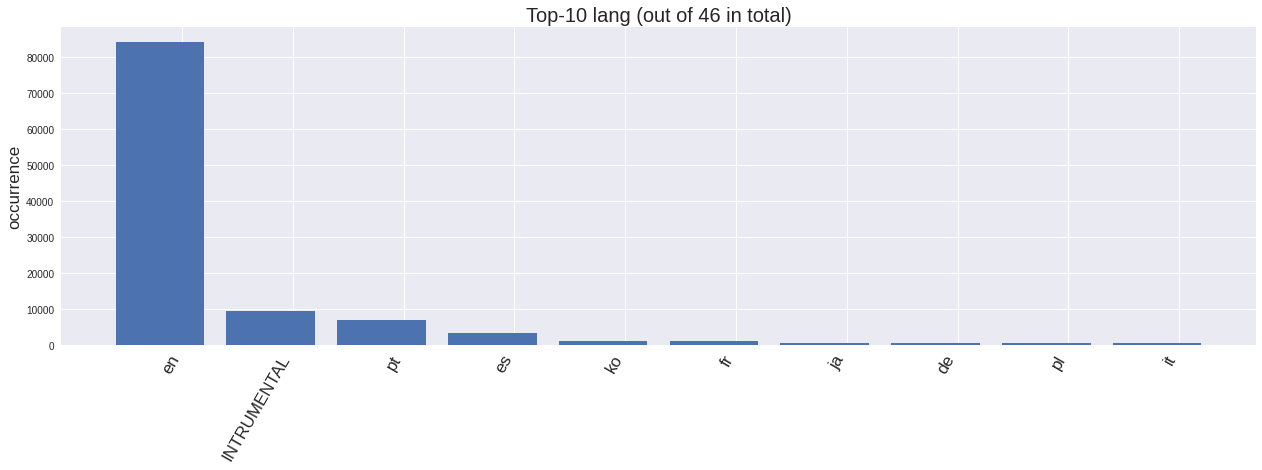

In [8]:
language_counter = analyze_genre_tag_csv('id_lang.csv', top_n=10)
print(language_counter)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-language.png'))

In [9]:
# create List of top10 language
#top_10_lang = ['en', 'INTRUMENTAL', 'pt', 'es', 'ko', 'fr', 'ja', 'de', 'pl', 'it']
top_10_lang = ['en', 'pt', 'es']

### Filter dataset as English, Portuguese, Spanish
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [10]:
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_top10=df_lang[ df_lang['lang'].isin(top_10_lang) ]
df_lang_top10

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


In [11]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_top10['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
14,00XWljDxNBgBKEEA,pop,es
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


Number of genres: 20


[('pop', 6092),
 ('rock', 1887),
 ('rap', 1431),
 ('soul', 1337),
 ('electronic', 1305),
 ('indie rock', 1182),
 ('folk', 1017),
 ('singer-songwriter', 794),
 ('indie pop', 714),
 ('punk', 402),
 ('alternative rock', 384),
 ('ambient', 330),
 ('post-hardcore', 267),
 ('experimental', 257),
 ('synthpop', 238),
 ('progressive rock', 234),
 ('hard rock', 203),
 ('classic rock', 185),
 ('metal', 175),
 ('new wave', 169)]

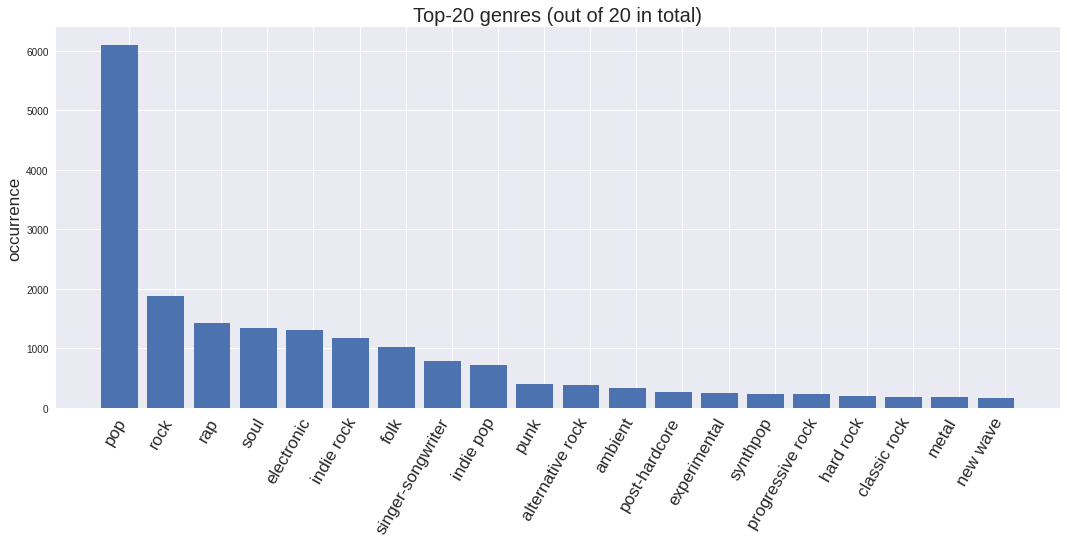

In [12]:
labels = analyze_genre_tag_df(df_genre_top20,20)
sorted_genres=sorted(labels.items(), key=lambda pair: pair[1], reverse=True)
sorted_genres 

In [13]:
#get genres at least 200 songs.
genre_list=[]
for genre, count in sorted_genres:
  if count > 1100:
    genre_list.append(genre)
genre_list

['pop', 'rock', 'rap', 'soul', 'electronic', 'indie rock']

In [14]:
len(genre_list)

6

In [15]:
df_genre_by_lang=df_genre_by_lang[ df_genre_by_lang['genres'].isin(genre_list) ]
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
14,00XWljDxNBgBKEEA,pop,es
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
...,...,...,...
109213,zxt2VX0vHKKbgbiz,rap,en
109249,zzT504Z94j1IAuc3,indie rock,en
109253,zzgS4ZqyswamEWNj,pop,en
109262,zzx8CWdM7qkxKQpC,indie rock,en


Number of genres: 6
Counter({'pop': 5631, 'rock': 1716, 'soul': 1305, 'rap': 1189, 'indie rock': 1141, 'electronic': 973})


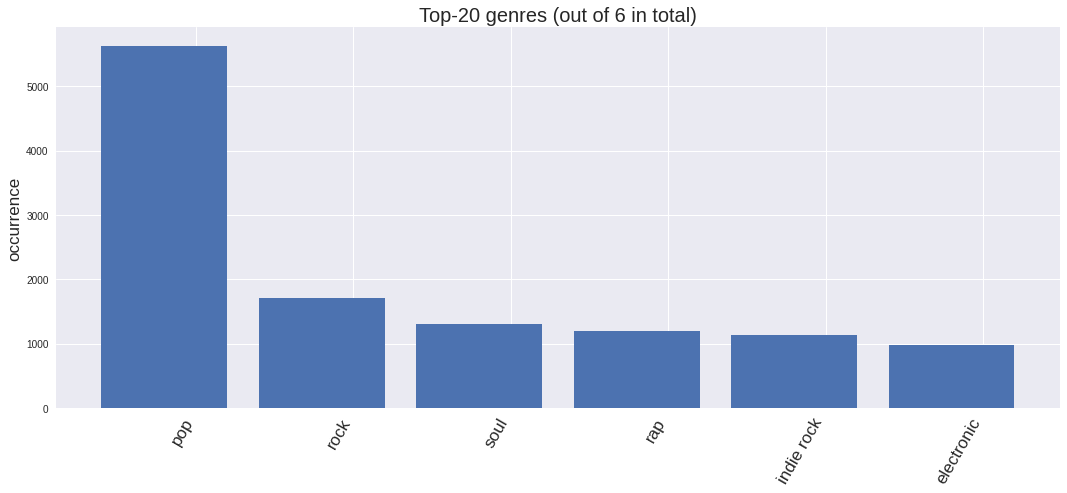

In [16]:
#Create gap for minor genres
#df_genre_by_lang.columns
genre_counter = analyze_genre_tag_df(df_genre_by_lang, top_n=20)
print(genre_counter)

In [17]:
#get gaps for minor genres
pop_count = 5631
genre_gap=[]


for (genre, count) in genre_counter.items():
  if genre != 'pop':
    if (genre, pop_count - count) not in genre_gap:
      genre_gap.append((genre, pop_count - count))

genre_gap

[('soul', 4326),
 ('rock', 3915),
 ('rap', 4442),
 ('electronic', 4658),
 ('indie rock', 4490)]

In [18]:
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split

In [19]:
#create df_all, which is putting lang and genre in a same column
# to run multi-label stratification.
df_genre_by_lang['all_labels'] = df_genre_by_lang[['genres', 'lang']].apply(lambda x: ','.join(x), axis=1)
df_genre_by_lang=df_genre_by_lang.drop(columns=['genres', 'lang'], axis=1)
df_genre_by_lang

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,all_labels
0,0009fFIM1eYThaPg,"pop,en"
11,00P2bHdWFkghmDqz,"soul,en"
14,00XWljDxNBgBKEEA,"pop,es"
16,00b6fV3nx5z2b8Ls,"pop,en"
26,013QDoTqbexEwkHr,"pop,en"
...,...,...
109213,zxt2VX0vHKKbgbiz,"rap,en"
109249,zzT504Z94j1IAuc3,"indie rock,en"
109253,zzgS4ZqyswamEWNj,"pop,en"
109262,zzx8CWdM7qkxKQpC,"indie rock,en"


 Important Note: after filtering/sorting or any data manipulation on datasets, we need to reindex data frame. Otherwise, multi-label stratification fails due to shape mismatch of X and y.

In [20]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,all_labels
0,0009fFIM1eYThaPg,"pop,en"
1,00P2bHdWFkghmDqz,"soul,en"
2,00XWljDxNBgBKEEA,"pop,es"
3,00b6fV3nx5z2b8Ls,"pop,en"
4,013QDoTqbexEwkHr,"pop,en"
...,...,...
11950,zxt2VX0vHKKbgbiz,"rap,en"
11951,zzT504Z94j1IAuc3,"indie rock,en"
11952,zzgS4ZqyswamEWNj,"pop,en"
11953,zzx8CWdM7qkxKQpC,"indie rock,en"


### Get lyrics document as dataframe and append to X_train, X_test

In [21]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,all_labels,lyric
0,0009fFIM1eYThaPg,"pop,en",
1,00P2bHdWFkghmDqz,"soul,en",
2,00XWljDxNBgBKEEA,"pop,es",
3,00b6fV3nx5z2b8Ls,"pop,en",
4,013QDoTqbexEwkHr,"pop,en",
...,...,...,...
11950,zxt2VX0vHKKbgbiz,"rap,en",
11951,zzT504Z94j1IAuc3,"indie rock,en",
11952,zzgS4ZqyswamEWNj,"pop,en",
11953,zzx8CWdM7qkxKQpC,"indie rock,en",


In [22]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

In [23]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      lyric_document=[' '.join([stemmer.stem(word.lower()) for word in lyric_document.split(' ')]) ]

      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#index 5001 ~ 10,000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:10000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #Stemming and normalization
      lyric_document=[' '.join([stemmer.stem(word.lower()) for word in lyric_document.split(' ')]) ]
      #print(lyric_document)

      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#index 10001 ~ 14696
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[10001:14696].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      lyric_document=[' '.join([stemmer.stem(word.lower()) for word in lyric_document.split(' ')]) ]
      
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
df_genre_by_lang[0:14696]

### Use multi-label stratification and problem transform approach: BinaryRelation, and ClassifierChain. http://scikit.ml/tutorial.html


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
# Multi Label Pkgs
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain

### Note: We can only fit only on the train set. 
As tfidf.fit_transform(X_train)
Then, vectors_test = vectorizer.transform(y_test)
pred = clf.predict(vectors_test)

### Understand http://scikit.ml/stratification.html

In [ ]:
!pip install liac-arff==2.2.1

  Created wheel for liac-arff: filename=liac_arff-2.2.1-py3-none-any.whl size=12052 sha256=7f5b98de4fb6bac0ed40c9cfd062f10c9ca7b45f8aab141476f06353d3a24435
  Stored in directory: /root/.cache/pip/wheels/1e/27/8b/35b66eae78ae7985ebdef46677fc2660976a0fb39651d92808
Successfully built liac-arff


In [ ]:
from skmultilearn.dataset import load_dataset

from skmultilearn.model_selection import IterativeStratification   
X,y, _, _ = load_dataset('scene', 'undivided')
print(X.shape)
print(y.shape)

scene:undivided - exists, not redownloading
(2407, 294)
(2407, 6)


### Step1: multi-label stratification

Note: We should split before tf-idf to avoid data leakage.

https://datascience.stackexchange.com/questions/100349/splitting-before-tfidf-or-after

In [29]:
class Splitter2:
    def __init__(self, df, test_size=0.2, top_n=1000, random_seed=None): #Xfeature
        if random_seed is not None:
            np.random.seed(random_seed)
        
        self.random_seed = random_seed
            
        column_name = df.columns[1]
        print('column name: %s' % column_name)
        items = df[column_name].tolist()  # list of 'genre1, genre2,..'
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        
        items = Counter(items)
        item_labels = [item[0] for item in items.most_common(top_n)] 
        print('Total number of items considered in the split: %d' % len(item_labels))

        item_to_index = {item: i for (i, item) in enumerate(item_labels)}

        row_inds, col_inds = [], []
        
        # create sparse matrix
        for index, genre_names in zip(df.index, df[column_name]):
            genre_list = genre_names.split(',')
            for genre in genre_list:
                row_inds.append(index)
                col_inds.append(item_to_index[genre])

        self.sparse_labels = csr_matrix((np.ones(len(row_inds)), (row_inds, col_inds)))
        
        # perform splitting
        #input_x = df.index
        #input_x = input_x.to_numpy().reshape((-1, 1))
        X_train, y_train, X_test, y_test = iterative_train_test_split(df[["id", "lyric"]].to_numpy(), self.sparse_labels, test_size=test_size) #Xfeature
        
        # print the result
        print(pd.DataFrame({
            'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train.A, order=2) for combination in row),
            'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test.A, order=2) for combination in row)
        }).T.fillna(0.0))
        
        self.column_name = column_name
        self.item_labels = item_labels
        self.items = items
        self.item_to_index = item_to_index
        self.split = X_train, y_train, X_test, y_test

#### This is ganna take 40sec.

In [30]:
#splitter2_all = Splitter2(Xfeature=Xfeatures, df=df_genre_by_lang, top_n=None, random_seed=1209)
splitter2_all = Splitter2( df=df_genre_by_lang, top_n=None, random_seed=1209)

column name: all_labels
Total number of items considered in the split: 9
       (1, 8)  (8, 8)  (1, 1)  (0, 1)  (0, 0)  (4, 7)  (4, 4)  (7, 7)  (0, 2)  \
train   177.0   315.0  4505.0  4143.0  8742.0   145.0   951.0   508.0  1159.0   
test     44.0    78.0  1126.0  1036.0  2186.0    36.0   238.0   126.0   290.0   

       (2, 2)  ...  (5, 5)  (4, 8)  (1, 7)  (3, 8)  (5, 8)  (2, 7)  (6, 8)  \
train  1373.0  ...   914.0    24.0   185.0     2.0    34.0   148.0    12.0   
test    343.0  ...   227.0     6.0    46.0     0.0     9.0    37.0     3.0   

       (3, 7)  (6, 7)  (5, 7)  
train    12.0     4.0    14.0  
test      3.0     1.0     3.0  

[2 rows x 27 columns]


In [31]:
X_train, y_train, X_test, y_test = splitter2_all.split
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9565, 2)
(9565, 9)
(2390, 2)
(2390, 9)


In [32]:
X_train

array([['00XWljDxNBgBKEEA',
        'mirándot a lo ojos, juraría que tien algo nuevo que contarm empieza ya mujer, no tenga miedo quizá para mañana sea tard quizá para mañana sea tard  ¿y cómo es él? ¿en qué lugar se enamoró de ti? ¿de dónde es? ¿a qué dedica el tiempo libre? pregúntale, ¿por qué ha robado un trozo de mi vida? es un ladrón que me ha robado todo  ¿y cómo es él? ¿en qué lugar es enamoró de ti? ¿de dónde es? ¿a qué dedica el tiempo libre? pregúntale, ¿por qué ha robado un trozo de mi vida? es un ladrón que me ha robado todo  arréglat mujer, se te hace tard y llévate el paraguas, por si lluev él te estará esperando para amart y yo estaré celoso de perdert  y abrígat te sienta bien ese vestido gri sonrí que, que no sospech que ha llorado y déjame, que vaya preparando mi equipaj perdóname, si te hago otra pregunta  ¿y cómo es él? ¿en qué lugar es enamoró de ti? ¿de dónde es? ¿a qué dedica el tiempo libre? pregúntale, ¿por qué ha robado un trozo de mi vida? es un ladrón que m

In [32]:
splitter2_all.item_labels

['en', 'pop', 'rock', 'soul', 'rap', 'indie rock', 'electronic', 'pt', 'es']

### Step2: Apply TF-IDF(X_train)

In [33]:
df_X_train = pd.DataFrame(data=X_train, columns=["id","lyric"])    # values
             # index=data[1:,0],    # 1st column as index
              

In [34]:
df_X_train

,id,lyric
0,00XWljDxNBgBKEEA,"mirándot a lo ojos, juraría que tien algo nuev..."
1,00b6fV3nx5z2b8Ls,a buh-buh buh buh-buh a buh-buh buh buh-buh y...
2,01I5p010ajulr0O5,i wa alon i wa made of stone you took me home ...
3,01roaWOWaMzXjMOV,"weekend in bed, no scrambl eggs, or bacon i ju..."
4,01zNMO11qGa7tLqa,"ela veio assim, disposta a aceitar minha propo..."
...,...,...
9560,zxt2VX0vHKKbgbiz,flexin' (bitch) smokin' grandma cooki nigga sh...
9561,zzT504Z94j1IAuc3,don't think it' what you'r afraid of come in y...
9562,zzgS4ZqyswamEWNj,"oh, yeah, yeah last night i took a walk in th..."
9563,zzx8CWdM7qkxKQpC,"innocence, it don't come easy, in a sens it ne..."


In [35]:
#build default uni-gram of TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(df_X_train['lyric']).toarray()
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
df_X_train_tfidf = pd.DataFrame(data=X_train_tfidf)    # values

In [37]:
df_X_train_tfidf

,0,1,2,3,4,5,6,7,8,9,...,40411,40412,40413,40414,40415,40416,40417,40418,40419,40420
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
#type(y_train)
#type(y_train.data)
y_train.toarray()

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 

### Step3: Resample (multi-label SMOTE) for minor genres.

In [38]:
#Recreate data fram after split because we only need X_train, y_train.
#ML-SMOTE is easy to create with data frame, not nd array
df_y_train = pd.DataFrame(data=y_train.toarray(),    # values
             # index=data[1:,0],    # 1st column as index
              columns=splitter2_all.item_labels)

In [39]:
df_y_train

,en,pop,rock,soul,rap,indie rock,electronic,pt,es
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
9560,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9561,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9562,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9563,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Apply ML-SMOTE


Small edit: we should not reindex in the get_minority_instace(X, y) fucntion.
This is because later we want to combine X_resample, y_resample to the original data frame. 
Also, can we only return the generated data? - yes, I modified the code in MLSMOTE(X,y,n_sample)
Original code:https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87


In [40]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  print("tail_label:",tail_labels)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

Note:  nearest_neighbour() has to be float value. But our X_train is id, lyric.

Because we can only TF-IDF after split.

So should we 
Step1: X_train, y_train, X_test, y_test = splitter2
Step2: apply TF-IDF for X_train.
Step3: resampling by nearest_neighbour(X):
Step4: fit_transform(X_test)

In [41]:
def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = abs(X.loc[reference,:] - X.loc[neighbour,:])
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    #new_X = pd.concat([X, new_X], axis=0) # do not concate, so we only get the artificial data.
    #target = pd.concat([y, target], axis=0)
    #later, we can append new_X, target to the original dataframe.
    return new_X, target

In [44]:
#X_sub, y_sub = get_minority_instace(df_X_train, df_y_train)
#df_y_train[df_y_train['pop'] < 1].index
#X_sub = df_X_train[df_X_train.index.isin(df_y_train[df_y_train['pop'] < 1].index)].reset_index(drop = True)
X_sub_rock = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['rock'] == 1].index)].reset_index(drop = True)
X_sub_soul = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['soul'] == 1].index)].reset_index(drop = True)
X_sub_rap = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['rap'] == 1].index)].reset_index(drop = True)
#X_sub_indie_pop = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['indie pop'] == 1].index)].reset_index(drop = True)
X_sub_electronic = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['electronic'] == 1].index)].reset_index(drop = True)
X_sub_indie_rock = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['indie rock'] == 1].index)].reset_index(drop = True)
#X_sub_folk = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['folk'] == 1].index)].reset_index(drop = True)
#X_sub_punk = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['punk'] == 1].index)].reset_index(drop = True)
#X_sub_singer_songwriter = df_X_train_tfidf[df_X_train_tfidf.index.isin(df_y_train[df_y_train['singer-songwriter'] == 1].index)].reset_index(drop = True)


In [45]:
y_sub_rock = df_y_train[ df_y_train['rock'] == 1].reset_index(drop = True)
y_sub_soul = df_y_train[ df_y_train['soul'] == 1].reset_index(drop = True)
y_sub_rap = df_y_train[ df_y_train['rap'] == 1].reset_index(drop = True)
y_sub_electronic = df_y_train[ df_y_train['electronic'] == 1].reset_index(drop = True)
y_sub_indie_rock = df_y_train[ df_y_train['indie rock'] == 1].reset_index(drop = True)
#y_sub_folk = df_y_train[ df_y_train['folk'] == 1].reset_index(drop = True)
#y_sub_punk = df_y_train[ df_y_train['punk'] == 1].reset_index(drop = True)
#y_sub_indie_pop = df_y_train[ df_y_train['indie pop'] == 1].reset_index(drop = True)
#y_sub_singer_songwriter = df_y_train[ df_y_train['singer-songwriter'] == 1].reset_index(drop = True)

We need to find the minimum rows of majority genres.
tail_label: ['singer-songwriter', 'pt', 'indie pop', 'es', 'punk']
the least non-minority genre is folk, 1017 rows. So set 1017 - 400 = 617 row more.

This ML-SMOTE is going to take 10 minutes.

In [46]:
#Compute different size between pop and other genres.
genre_gap

[('soul', 4326),
 ('rock', 3915),
 ('rap', 4442),
 ('electronic', 4658),
 ('indie rock', 4490)]

In [47]:
soul_gap = ('soul', 4326)
rock_gap = ('rock', 3915)
rap_gap = ('rap', 4442)
#indie_pop_gap = ('indie pop', 4932)
electronic_gap = ('electronic', 4658)
#folk_gap = ('folk', 4696)
#punk_gap = ('punk', 5243)
indie_rock_gap= ('indie rock', 4490)
#singer_songwriter_gap = ('singer-songwriter', 4912)

In [87]:
X_sub_rock.shape

(1373, 2)

In [48]:
X_res_rock,y_res_rock =MLSMOTE(X_sub_rock, y_sub_rock, rock_gap[1])

In [49]:
X_res_soul,y_res_soul =MLSMOTE(X_sub_soul, y_sub_soul, soul_gap[1])

In [50]:
X_res_rap, y_res_rap =MLSMOTE(X_sub_rap, y_sub_rap, rap_gap[1])

In [96]:
#X_res_indie_pop, y_res_indie_pop = MLSMOTE(X_sub_indie_pop, y_sub_indie_pop, indie_pop_gap[1])

In [51]:
X_res_electronic, y_res_electronic = MLSMOTE(X_sub_electronic, y_sub_electronic, electronic_gap[1])

In [98]:
#X_res_folk, y_res_folk = MLSMOTE(X_sub_folk, y_sub_folk, folk_gap[1])

In [99]:
#X_res_punk, y_res_punk = MLSMOTE(X_sub_punk, y_sub_punk, punk_gap[1])

In [52]:
X_res_indie_rock, y_res_indie_rock = MLSMOTE(X_sub_indie_rock, y_sub_indie_rock, indie_rock_gap[1])

In [125]:
#X_res_singer_songwriter, y_res_singer_songwriter = MLSMOTE(X_sub_singer_songwriter, y_sub_singer_songwriter, singer_songwriter_gap[1])

In [104]:
X_res_rock

,0,1,2,3,4,5,6,7,8,9,...,43500,43501,43502,43503,43504,43505,43506,43507,43508,43509
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


You can only concatenate once! If you repeate, the number of rows is double.

In [53]:
print("df_X_train_tfidf:",df_X_train_tfidf.shape)
df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf, X_res_rock], ignore_index=True)
print("df_X_train_tfidf After:",df_X_train_tfidf.shape)

df_X_train_tfidf: (9565, 40421)
df_X_train_tfidf After: (9565, 40421)


In [54]:
print("df_X_train_tfidf:",df_y_train.shape)
df_y_train_concate = pd.concat([df_y_train, y_res_rock], ignore_index=True)
print("df_y_train_concate After:",df_y_train_concate.shape)

df_X_train_tfidf: (9565, 9)
df_y_train_concate After: (13480, 9)


In [55]:
print("df_X_train_tfidf_concate:",df_X_train_tfidf_concate.shape)
df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf_concate, X_res_soul], ignore_index=True)
print("df_X_train_tfidf_concate After:",df_X_train_tfidf_concate.shape)

df_X_train_tfidf_concate: (13480, 40421)
df_X_train_tfidf_concate After: (17806, 40421)


In [56]:
print("df_y_train_tfidf:",df_y_train_concate.shape)
df_y_train_concate = pd.concat([df_y_train_concate, y_res_soul], ignore_index=True)
print("df_y_train_concate After:",df_y_train_concate.shape)

df_y_train_tfidf: (13480, 9)
df_y_train_concate After: (17806, 9)


In [57]:
print("df_X_train_tfidf_concate:",df_X_train_tfidf_concate.shape)
df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf_concate, X_res_rap], ignore_index=True)
print("df_X_train_tfidf_concate After:",df_X_train_tfidf_concate.shape)

df_X_train_tfidf_concate: (17806, 40421)
df_X_train_tfidf_concate After: (22248, 40421)


In [58]:
print("df_y_train_tfidf:",df_y_train_concate.shape)
df_y_train_concate = pd.concat([df_y_train_concate, y_res_rap], ignore_index=True)
print("df_y_train_concate After:",df_y_train_concate.shape)

df_y_train_tfidf: (17806, 9)
df_y_train_concate After: (22248, 9)


In [116]:
#print("df_X_train_tfidf_concate:",df_X_train_tfidf_concate.shape)
#df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf_concate, X_res_indie_pop], ignore_index=True)
#print("df_X_train_tfidf_concate After:",df_X_train_tfidf_concate.shape)

df_X_train_tfidf_concate: (24443, 43510)
df_X_train_tfidf_concate After: (29375, 43510)


In [117]:
#print("df_y_train_tfidf:",df_y_train_concate.shape)
#df_y_train_concate = pd.concat([df_y_train_concate, y_res_indie_pop], ignore_index=True)
#print("df_y_train_concate After:",df_y_train_concate.shape)

df_y_train_tfidf: (24443, 13)
df_y_train_concate After: (29375, 13)


In [59]:
print("df_X_train_tfidf_concate:",df_X_train_tfidf_concate.shape)
df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf_concate, X_res_electronic], ignore_index=True)
print("df_X_train_tfidf_concate After:",df_X_train_tfidf_concate.shape)

df_X_train_tfidf_concate: (22248, 40421)
df_X_train_tfidf_concate After: (26906, 40421)


In [60]:
print("df_y_train_tfidf:",df_y_train_concate.shape)
df_y_train_concate = pd.concat([df_y_train_concate, y_res_electronic], ignore_index=True)
print("df_y_train_concate After:",df_y_train_concate.shape)

df_y_train_tfidf: (22248, 9)
df_y_train_concate After: (26906, 9)


In [120]:
#print("df_X_train_tfidf_concate:",df_X_train_tfidf_concate.shape)
#df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf_concate, X_res_folk], ignore_index=True)
#print("df_X_train_tfidf_concate After:",df_X_train_tfidf_concate.shape)

df_X_train_tfidf_concate: (34033, 43510)
df_X_train_tfidf_concate After: (38729, 43510)


In [121]:
#print("df_y_train_tfidf:",df_y_train_concate.shape)
#df_y_train_concate = pd.concat([df_y_train_concate, y_res_folk], ignore_index=True)
#print("df_y_train_concate After:",df_y_train_concate.shape)

df_y_train_tfidf: (34033, 13)
df_y_train_concate After: (38729, 13)


In [61]:
print("df_X_train_tfidf_concate:",df_X_train_tfidf_concate.shape)
df_X_train_tfidf_concate = pd.concat([df_X_train_tfidf_concate, X_res_indie_rock], ignore_index=True)
print("df_X_train_tfidf_concate After:",df_X_train_tfidf_concate.shape)

df_X_train_tfidf_concate: (26906, 40421)
df_X_train_tfidf_concate After: (31396, 40421)


In [62]:
print("df_y_train_tfidf:",df_y_train_concate.shape)
df_y_train_concate = pd.concat([df_y_train_concate, y_res_indie_rock], ignore_index=True)
print("df_y_train_concate After:",df_y_train_concate.shape)

df_y_train_tfidf: (26906, 9)
df_y_train_concate After: (31396, 9)


### Note: Tf-idf is tf, a non-negative value, times idf, a non-negative value, so it can never be negative

In [ ]:
#debug
np.set_printoptions(threshold=sys.maxsize)
result = np.where(X_train == np.amin(X_train))
result
print(X_train[12183])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

### Approach1 Binary Relevance classficiation
Binary Relevance classficiation Converts Our Multi-Label Prob to Multi-Class.
Binary Relevance classficiation treats each label as a single classification problem. Because it treats as a separate problem, there is no correlation between genre and language.

binary_rel_clf.fit(X_train,y_train) will take 3 minutes.

#### Follow this: https://coderzcolumn.com/tutorials/machine-learning/how-to-use-eli5-to-understand-sklearn-models-their-performance-and-their-predictions


In [63]:
#convert dataframe to sparsematrix
import scipy


In [64]:
binary_rel_clf = BinaryRelevance(MultinomialNB())
binary_rel_clf.fit(scipy.sparse.csr_matrix(df_X_train_tfidf_concate.values)
, scipy.sparse.csr_matrix(df_y_train_concate.values))

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [65]:
df_X_test = pd.DataFrame(data=X_test, columns=["id","lyric"])  
df_X_test
# Predictions
#br_prediction = binary_rel_clf.predict(X_test)

,id,lyric
0,0009fFIM1eYThaPg,"it' a sunni day, so i got nowher to hide not a..."
1,00P2bHdWFkghmDqz,"tell me a tale that alway was, sing me a song ..."
2,013QDoTqbexEwkHr,"it' like a conversation, where no-on stop to b..."
3,01EKNot8qVgZpKM7,say the word i cannot say say them on anoth da...
4,01OcWE6ZDS0RAb4I,lock up tight like i would never feel again st...
...,...,...
2385,SfFUwCSJJ5zfLXy4,es terribl percibir que te va y no sabe el dol...
2386,Sjq8nppDrFPrZwBO,"oh yeah, oh yeah (ooh) oh como un bello amanec..."
2387,SmSqvwbSstgJu1E4,no calculé mi intencion no estaba listo para h...
2388,WRz3f6tSlCYUCEJo,como um velho boiadeiro tangendo a si mesmo se...


In [66]:
#Apply TF-IDF to X_test. Make sure we get the same size of features.
X_test_tfidf = tfidf_vectorizer.transform(df_X_test['lyric']).toarray()

In [67]:
print("Train/Test Vector Size : ", X_train_tfidf.shape, X_test_tfidf.shape)

Train/Test Vector Size :  (9565, 40421) (2390, 40421)


In [68]:
X_test_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
# Predictions
br_prediction = binary_rel_clf.predict(X_test_tfidf)

In [70]:
br_prediction.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [71]:
br_prediction.shape

(2390, 9)

In [72]:
# Accuracy
#accuracy_score(y_test,br_prediction)
from sklearn.metrics import jaccard_score
#when we run classification on multi-label, use average=''samples''
jaccard_score(y_test, br_prediction, average='samples')

0.5228242677824269

Use Balanced Accuracy:
https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score

In [76]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, br_prediction)

ValueError: ignored

In [73]:
# Hamming Loss counts Incorrect Predictions
# The Lower the result the better
hamming_loss(y_test, br_prediction)

0.11306369130636913

In [74]:
#debug
print(splitter2_all.item_to_index)
print(y_test.toarray()[0]) 

print(br_prediction.toarray()[0])

{'en': 0, 'pop': 1, 'rock': 2, 'soul': 3, 'rap': 4, 'indie rock': 5, 'electronic': 6, 'pt': 7, 'es': 8}
[1. 1. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [77]:
from typing import List
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

def multilabel_confusion_matirx(splitter2_all, y_test, classifier_prediction)->List:
  confusion_mat_dict={}
  labels = splitter2_all.item_labels

  #f1_scores_labels = []
  precision_labels = []
  for label_col in range(len(splitter2_all.item_labels)):
      y_true_label = y_test.toarray()[:, label_col]
      y_pred_label = classifier_prediction.toarray()[:, label_col]
      #f1 = f1_score(y_true_label, y_pred_label, average='weighted')
      precision = precision_score(y_true_label, y_pred_label, average='weighted')
      #print("f1_score:", f1)
      print("precision:" , precision)
      #f1_scores_labels.append((labels[label_col] , f1))
      precision_labels.append((labels[label_col] , precision))

      confusion_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


  for label, matrix in confusion_mat_dict.items():
      print("Confusion matrix for label {}:".format(label))
      print(matrix)
  return precision_labels

Note: The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives

In [78]:
def plot_confusion(f1_scores_labels):
  names, f1_scores = list(zip(*f1_scores_labels))

  xs = np.arange(len(names))
  plt.figure(figsize=(18, 7))
  plt.bar(xs, f1_scores)
  plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
  #plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
  plt.ylabel('occurrence', size=17)

In [79]:
precision_labels = multilabel_confusion_matirx(splitter2_all, y_test, br_prediction)

precision: 0.9995836309827534
precision: 0.6173649629087811
precision: 0.7784735942613031
precision: 0.868824932874924
precision: 0.9185627391366087
precision: 0.8430428370515595
precision: 0.8767260510688315
precision: 0.9983778564531702
precision: 0.9995868862878026
Confusion matrix for label en:
[[ 204    0]
 [   1 2185]]
Confusion matrix for label pop:
[[1258    6]
 [1111   15]]
Confusion matrix for label rock:
[[1911  136]
 [ 296   47]]
Confusion matrix for label soul:
[[2125    4]
 [ 253    8]]
Confusion matrix for label rap:
[[2054   98]
 [  97  141]]
Confusion matrix for label indie rock:
[[2160    3]
 [ 226    1]]
Confusion matrix for label electronic:
[[2192    3]
 [ 193    2]]
Confusion matrix for label pt:
[[2260    4]
 [   0  126]]
Confusion matrix for label es:
[[2311    1]
 [   0   78]]


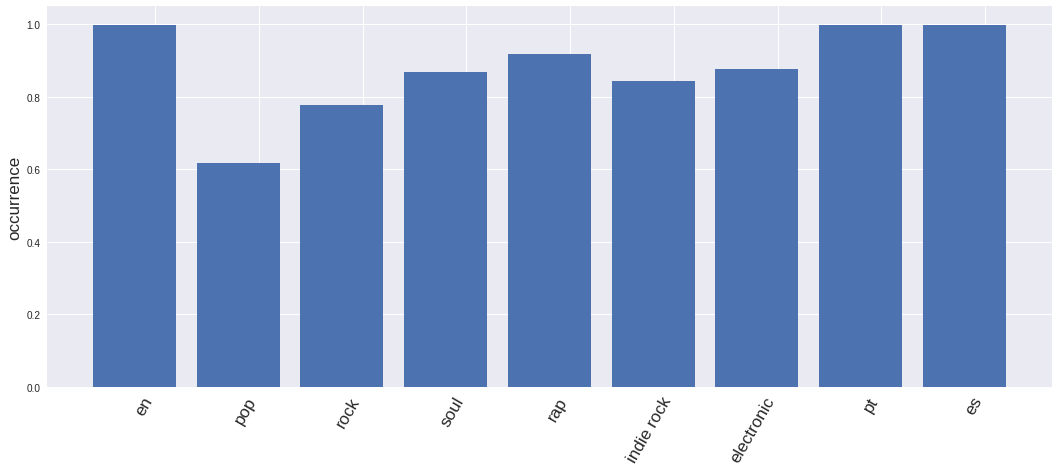

In [80]:
plot_confusion(precision_labels)

 The lowest precision (= high false positive) is Pop, follower by rock.
=> Even though we increased size of mino genres, still false positive of pop is the highest. It makes sense because pop is sort of base of today's songs, so it's easy to miss predict.

### Approach2: Classifier Chains 
Classifier Chains preserves the correlation between genre and language. So in the large dataset, Classifier Chains possibly perform better than binary relation.

So MultinomialNB() is a base classifier, and ClassifierChain() is a problem transformer. 

fit() will take about 3 mins.

In [81]:
# Create an Instance and fit()
classifier_chain_clf = ClassifierChain(MultinomialNB())
#clf.fit(X_train, y_train)
classifier_chain_clf.fit(scipy.sparse.csr_matrix(df_X_train_tfidf_concate.values)
, scipy.sparse.csr_matrix(df_y_train_concate.values))

ClassifierChain(classifier=MultinomialNB(), require_dense=[True, True])

In [82]:
# Predict
#clf_predictions = clf.predict(X_test)
classifier_chain_prediction = classifier_chain_clf.predict(X_test_tfidf)

In [83]:
# Check For Accuracy by Jaccord similarlity
from sklearn.metrics import jaccard_score
#when we run classification on multi-label, use average=''samples''
jaccard_score(y_test, classifier_chain_prediction, average='samples')

0.5290794979079498

In [84]:
precision_labels_classifier_chain = multilabel_confusion_matirx(splitter2_all, y_test, classifier_chain_prediction)

precision: 0.9995836309827534
precision: 0.5948392557983804
precision: 0.7807348783684005
precision: 0.868824932874924
precision: 0.9457513036425979
precision: 0.8430428370515595
precision: 0.8712555460391451
precision: 0.997603651578547
precision: 0.9991639031834604
Confusion matrix for label en:
[[ 204    0]
 [   1 2185]]
Confusion matrix for label pop:
[[1256    8]
 [1110   16]]
Confusion matrix for label rock:
[[1923  124]
 [ 297   46]]
Confusion matrix for label soul:
[[2125    4]
 [ 253    8]]
Confusion matrix for label rap:
[[2136   16]
 [ 108  130]]
Confusion matrix for label indie rock:
[[2160    3]
 [ 226    1]]
Confusion matrix for label electronic:
[[2191    4]
 [ 193    2]]
Confusion matrix for label pt:
[[2258    6]
 [   0  126]]
Confusion matrix for label es:
[[2312    0]
 [   2   76]]


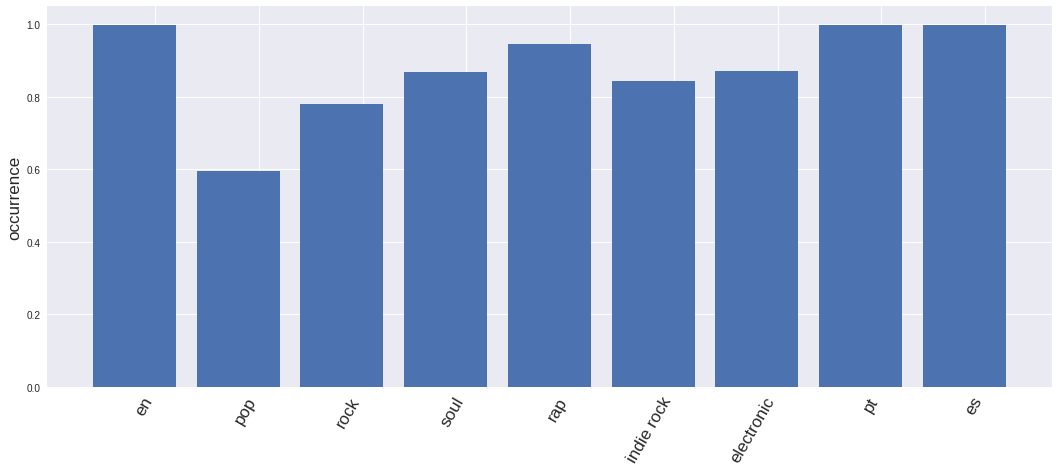

In [85]:
plot_confusion(precision_labels_classifier_chain)

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

labels = ['en','pop','rock', 'soul', 'rap', 'indie rock', 'electronic', 'pt', 'es']

#predictions_one_hot = model.predict(test_data)
cm = confusion_matrix(y_test.argmax(axis=1), classifier_chain_prediction.argmax(axis=1))
print(cm)

[[2185    0    0    0    1    0    0    0]
 [   0   15   69    0    5    0    0    1]
 [   0    4   46    0    2    0    0    1]
 [   0    0    3    0    0    0    0    0]
 [   0    2   38    0    2    0    0    0]
 [   0    2   10    0    0    0    0    0]
 [   0    0    3    0    1    0    0    0]
 [   0    0    0    0    0    0    0    0]]


In [95]:
y_test.argmax(axis=1)

matrix([[0],
        [0],
        [0],
        ...,
        [2],
        [5],
        [6]])

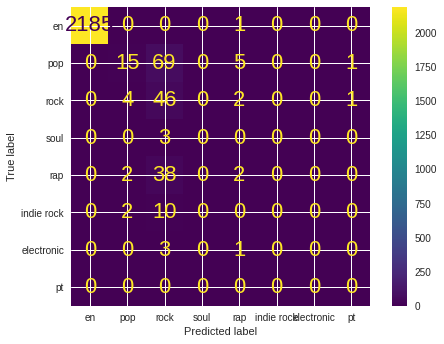

In [93]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp = disp.plot()
#include_values=include_values,
#                 cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

plt.show()

Language detection is perfect.

But again, precision is low for pop, rock for the same reason.
To find a way to improve this false positive issue, we can next take a look at Part of speech tagging to see if there is any difference between Pop, Rock and other genres.